# Indentify contaminant problem

The task is to predict why some batches of dog food are spoiling much quicker than intended. Unfortunately the Dog Food company hasn't upgraded its machinery, meaning that the amounts of the five preservative chemicals they are using vary a lot. The objective is to identify which chemical has the strongest effect.

The dog food company first mixes up a batch of preservative that contains 4 different preservative chemicals (A,B,C,D) and then is completed with a "filler" chemical. The food scientists beelive one of the A,B,C, or D preservatives is causing the problem.

Find out which parameter has the most predicitive power, thus finding out which chemical causes the early spoiling.

* Pres_A : Percentage of preservative A in the mix
* Pres_B : Percentage of preservative B in the mix
* Pres_C : Percentage of preservative C in the mix
* Pres_D : Percentage of preservative D in the mix
* Spoiled: Label indicating whether or not the dog food batch was spoiled.

In [2]:
import findspark
findspark.init('/home/matt/spark-3.1.1-bin-hadoop2.7')

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('dogfood').getOrCreate()

In [4]:
# Load training data
data = spark.read.csv('dog_food.csv',inferSchema=True,header=True)

In [5]:
data.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)



In [8]:
data.show(5)

+---+---+----+---+-------+
|  A|  B|   C|  D|Spoiled|
+---+---+----+---+-------+
|  4|  2|12.0|  3|    1.0|
|  5|  6|12.0|  7|    1.0|
|  6|  2|13.0|  6|    1.0|
|  4|  2|12.0|  1|    1.0|
|  4|  2|12.0|  3|    1.0|
+---+---+----+---+-------+
only showing top 5 rows



In [7]:
data.describe().show()

+-------+------------------+------------------+------------------+------------------+-------------------+
|summary|                 A|                 B|                 C|                 D|            Spoiled|
+-------+------------------+------------------+------------------+------------------+-------------------+
|  count|               490|               490|               490|               490|                490|
|   mean|  5.53469387755102| 5.504081632653061| 9.126530612244897| 5.579591836734694| 0.2857142857142857|
| stddev|2.9515204234399057|2.8537966089662063|2.0555451971054275|2.8548369309982857|0.45221563164613465|
|    min|                 1|                 1|               5.0|                 1|                0.0|
|    max|                10|                10|              14.0|                10|                1.0|
+-------+------------------+------------------+------------------+------------------+-------------------+



## Feature engineering

In [10]:
# Import VectorAssembler and Vectors
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

In [11]:
data.columns

['A', 'B', 'C', 'D', 'Spoiled']

In [12]:
assembler = VectorAssembler(inputCols=['A', 'B', 'C', 'D'],outputCol="features")

In [19]:
output = assembler.transform(data)

In [22]:
output.printSchema()

root
 |-- A: integer (nullable = true)
 |-- B: integer (nullable = true)
 |-- C: double (nullable = true)
 |-- D: integer (nullable = true)
 |-- Spoiled: double (nullable = true)
 |-- features: vector (nullable = true)



In [21]:
final_data = output.select('features','Spoiled')

## Train model

In [23]:
from pyspark.ml.classification import RandomForestClassifier,DecisionTreeClassifier

In [24]:
rfc = DecisionTreeClassifier(labelCol='Spoiled',featuresCol='features')

In [25]:
rfc_model = rfc.fit(final_data)

In [26]:
rfc_model.featureImportances

SparseVector(4, {1: 0.0019, 2: 0.9832, 3: 0.0149})

Feature at index 2 (Chemical C) is by far the most important feature, meaning it is causing the early spoilage!

In [31]:
# Sanity check data by plotting spoiled with chemicl 'C'
import matplotlib.pyplot as plt

In [32]:
df = data.toPandas()

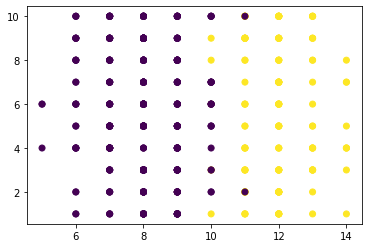

In [33]:
# plot 'C' chemical vs. 'D' chemical and highlight if spoiled
plt.scatter(df['C'],df['D'],c=df['Spoiled'])